# Model 1 - Custom - Generate data low frequency

In [1]:
using Statistics, LinearAlgebra, JUDI, SlimOptim, PyPlot, ImageFiltering, JLD, HDF5, SegyIO

## Velocity

In [2]:
n = (101, 101)  # Number of grid point (nx, nz)
d = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
o = (0., 0.);  # What is the location of the top left corner. This is necessary to define
# velocities
v = 1.5f0 * ones(Float32, n)
v[:, 31:66] .= 1.5f0 + 0.5f0
v[:, 66:end] .= 1.5f0 + 1.5f0
v[41:61, 36:56] .= 1.5f0 + 1.0f0;

# Create initial model and smooth the boundaries
v0 = imfilter(v, Kernel.gaussian((5,5)));

# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2
m0 = (1f0 ./ v0).^2
dm = vec(m0 - m);

# Setup model structure
model = Model(n, d, o, m)
model0 = Model(n, d, o, m0);

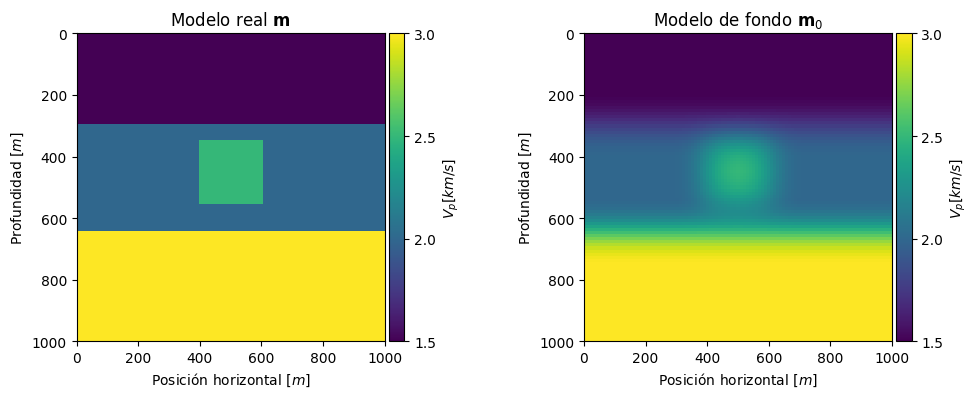

In [3]:
fig=figure(figsize=(12,4));
subplot(121)
im = imshow(v', cmap="viridis", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0])
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo real $\mathbf{m}$")
subplot(122)
im = imshow(v0', cmap="viridis", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0])
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo de fondo $\mathbf{m}_0$")
display(fig)

## Geometría de adquisición

In [4]:
# Fuentes
nsrc = 21
# Receptores
nxrec = 101
xrec = range(0f0, stop=(n[1]-1)*d[1], length=nxrec)
yrec = 0f0 # Cero para el eje y, 2D
zrec = range(30f0, stop=30f0, length=nxrec)

# intervalo de tiempo y tiempo total de grabacion
timeD = 1000f0   # tiempo de grabacion [ms]
dtD = 2f0    # intervalo de muestreo [ms]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dtD, t=timeD, nsrc=nsrc)

xsrc = convertToCell(range(0f0, stop=(n[1]-1)*d[1], length=nsrc))
ysrc = convertToCell(range(0f0, stop=0f0, length=nsrc))
zsrc = convertToCell(range(30f0, stop=30f0, length=nsrc))

# Set up source structure
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dtD, t=timeD)

GeometryIC{Float32} wiht 21 sources


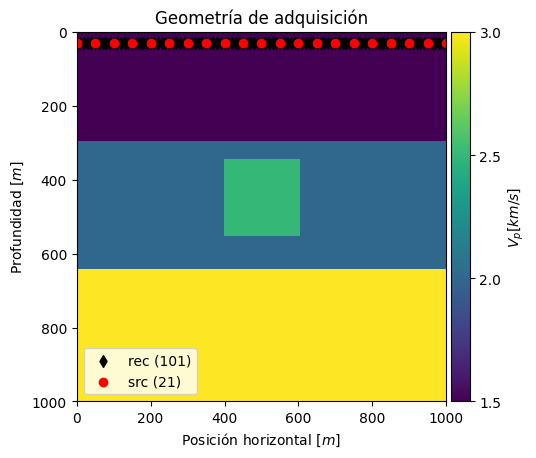

In [5]:
fig=figure();
im = imshow(v', cmap="viridis", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0])
scatter(xrec, zrec, label="rec (101)", color="black", marker="d")
scatter(xsrc, zsrc, label="src (21)", color="red")
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Geometría de adquisición")
legend();
display(fig)

## Low frequency - 4 Hz

In [6]:
# Ondicula
f0 = 0.004f0     # kHz 4Hz
wavelet = ricker_wavelet(timeD, dtD, f0)
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 21 sources


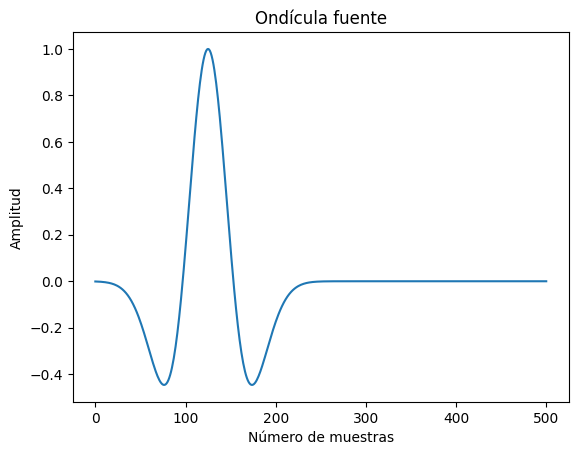

In [7]:
fig=figure()
plot(wavelet)
xlabel("Número de muestras")
ylabel("Amplitud")
title("Ondícula fuente")
display(fig)

In [8]:
opt = Options(optimal_checkpointing = true)    # set to false to disable optimal checkpointing
# Operadores
Pr = judiProjection(recGeometry)
F = judiModeling(model; options=opt)
F0 = judiModeling(model0; options=opt)
Ps = judiProjection(srcGeometry)
J = judiJacobian(Pr*F0*adjoint(Ps), q)

JUDI born{Float32} propagator (z * x) -> (src * rec * time)


### Datos observados $d_{\text{obs}}$

In [9]:
# Modelado no lineal
d_obs = Pr*F*adjoint(Ps)*q

Building forward operator
/home/geouser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geouser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.03 s
Ope

judiVector{Float32, Matrix{Float32}} with 21 sources


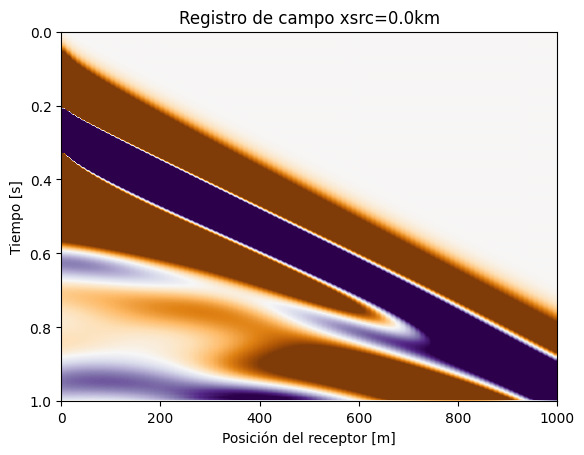

In [10]:
fig = figure() #dpi=300
imshow(d_obs.data[1], vmin=-1, vmax=1, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
xlabel("Posición del receptor [m]")
ylabel("Tiempo [s]")
title("Registro de campo xsrc=0.0km")
display(fig)

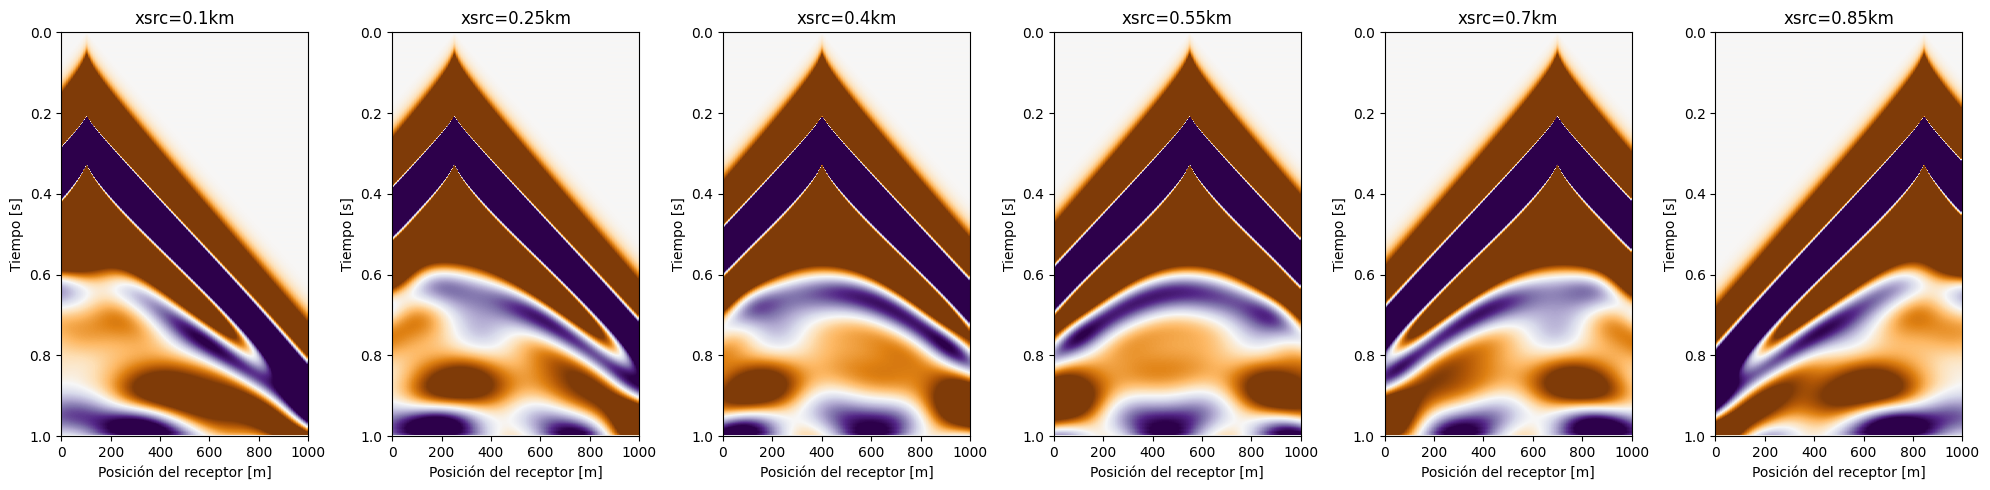

In [11]:
fig=figure(figsize=(20, 5)) #, dpi=300
for i=1:6
    subplot(1, 6, i)
    imshow(d_obs.data[3*i], vmin=-1, vmax=1, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
    xlabel("Posición del receptor [m]")
    ylabel("Tiempo [s]")
    title("xsrc=$(round(1f-3xsrc[3*i][1]; digits = 2))km")
end

tight_layout()
display(fig)

### Datos lineales 

In [12]:
dm = vec(model.m - model0.m);

In [13]:
# Linearized modeling J*dm
dD = J*dm

Building born operator
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s


judiVector{Float32, Matrix{Float32}} with 21 sources


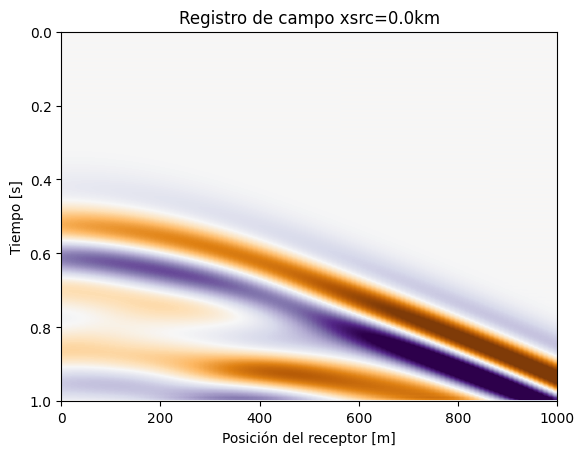

In [14]:
fig = figure() #dpi=300
imshow(dD.data[1], vmin=-1, vmax=1, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
xlabel("Posición del receptor [m]")
ylabel("Tiempo [s]")
title("Registro de campo xsrc=0.0km")
display(fig)

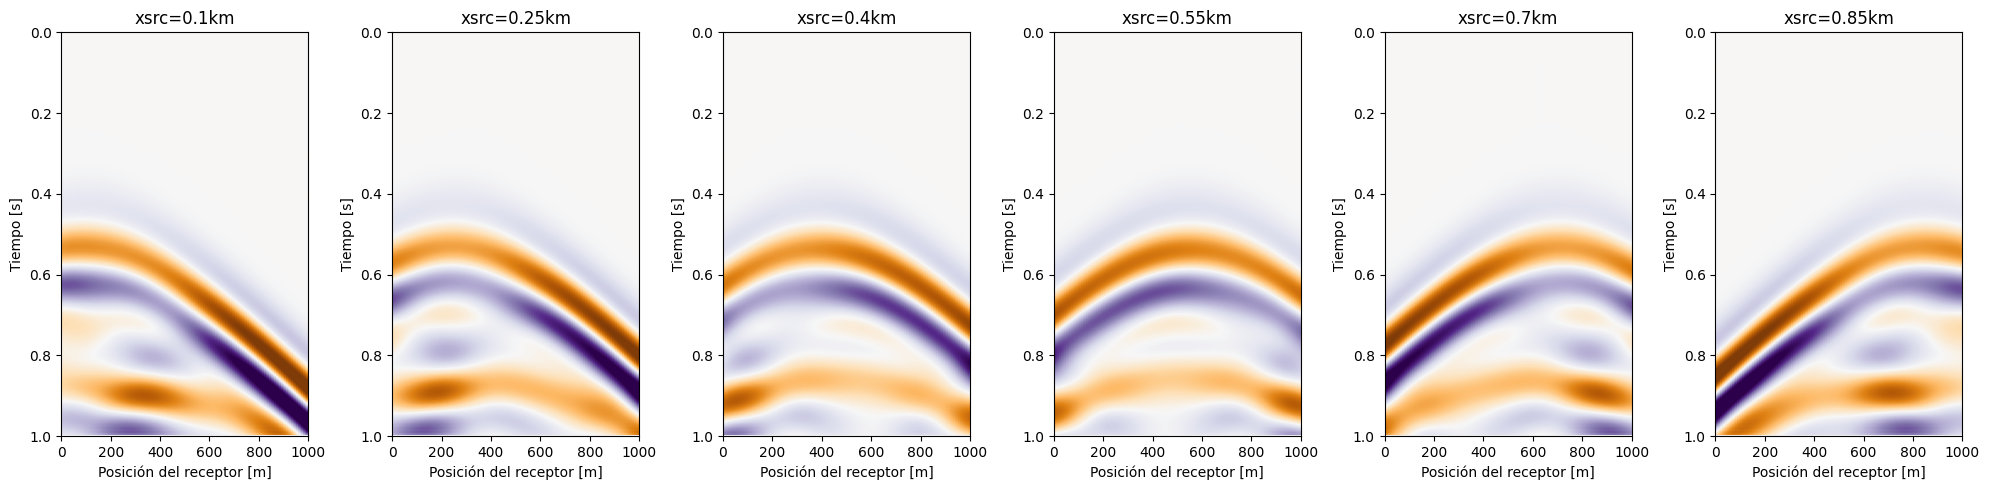

In [15]:
fig=figure(figsize=(20, 5)) #, dpi=300
for i=1:6
    subplot(1, 6, i)
    imshow(dD.data[3*i], vmin=-1, vmax=1, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
    xlabel("Posición del receptor [m]")
    ylabel("Tiempo [s]")
    title("xsrc=$(round(1f-3xsrc[3*i][1]; digits = 2))km")
end

tight_layout()
display(fig)

### Modelos y SEG-Y

In [16]:
save("model_custom.jld", "n", n, "d", d, "o", o, "m", m, "m0", m0, "dm", dm)

In [17]:
block = judiVector_to_SeisBlock(d_obs, q)
segy_write("model_custom_low_f.segy", block)  # writes a SEG-Y file called new_file.segy

In [18]:
block = judiVector_to_SeisBlock(dD, q)
segy_write("model_custom_low_f_lin.segy", block)  # writes a SEG-Y file called new_file.segy

## High frequency 15

In [19]:
# Ondicula
f0 = 0.015f0     # kHz 4Hz
wavelet = ricker_wavelet(timeD, dtD, f0)
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 21 sources


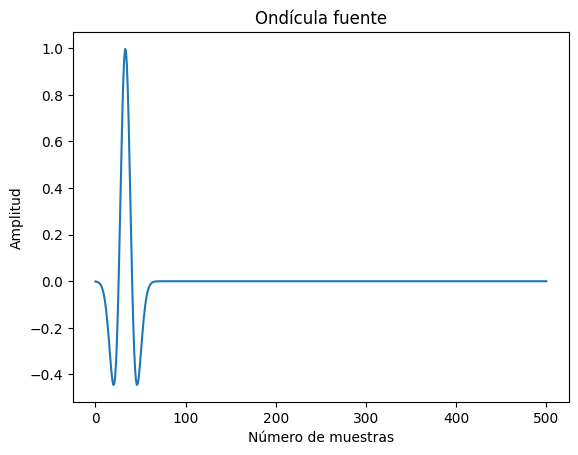

In [20]:
fig=figure()
plot(wavelet)
xlabel("Número de muestras")
ylabel("Amplitud")
title("Ondícula fuente")
display(fig)

In [21]:
opt = Options(optimal_checkpointing = true)    # set to false to disable optimal checkpointing
# Operadores
Pr = judiProjection(recGeometry)
F = judiModeling(model; options=opt)
F0 = judiModeling(model0; options=opt)
Ps = judiProjection(srcGeometry)
J = judiJacobian(Pr*F0*adjoint(Ps), q)

JUDI born{Float32} propagator (z * x) -> (src * rec * time)


In [22]:
# Modelado no lineal
d_obs = Pr*F*adjoint(Ps)*q

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.02 s
Operator `forward` ran in 0.01 s


judiVector{Float32, Matrix{Float32}} with 21 sources


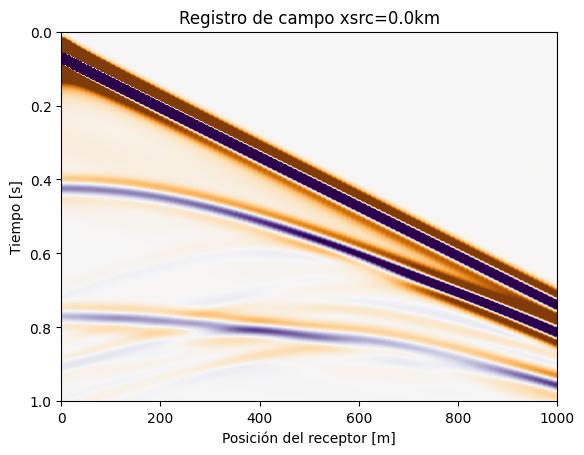

In [23]:
fig = figure() #dpi=300
imshow(d_obs.data[1], vmin=-1, vmax=1, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
xlabel("Posición del receptor [m]")
ylabel("Tiempo [s]")
title("Registro de campo xsrc=0.0km")
display(fig)

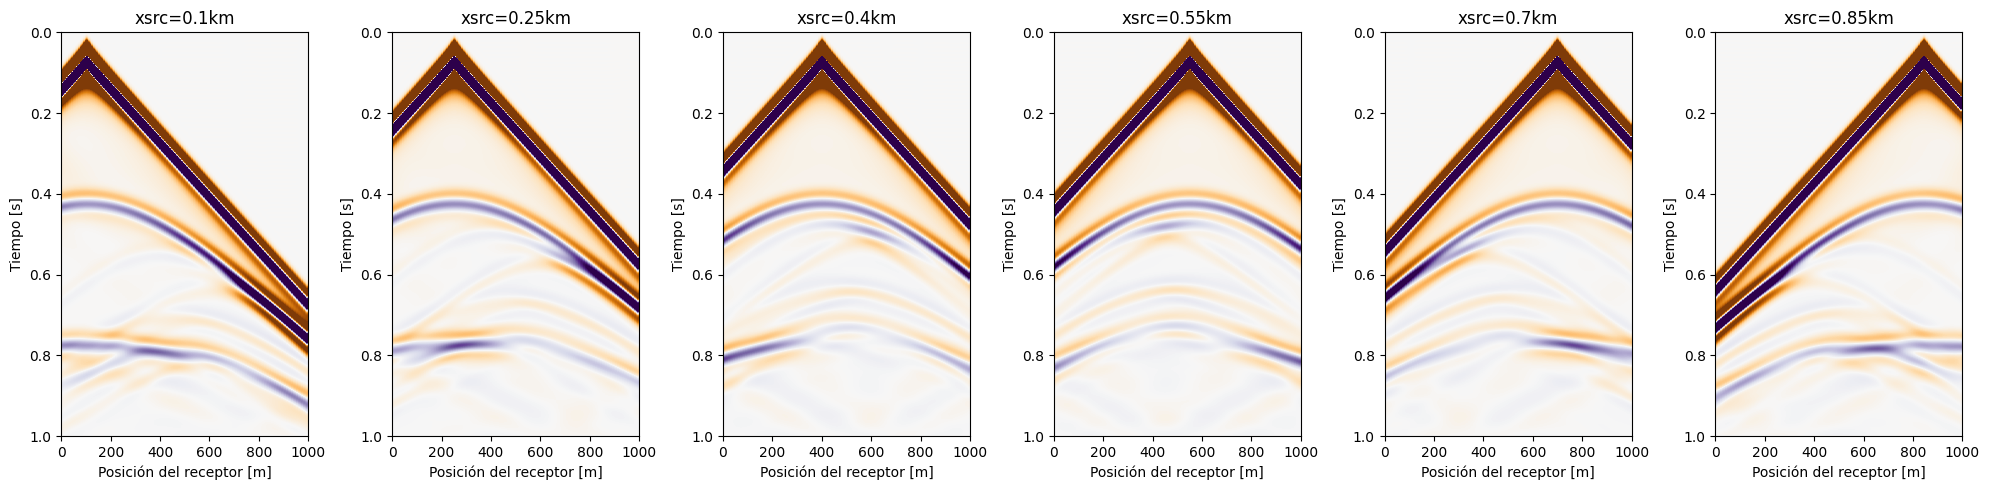

In [24]:
fig=figure(figsize=(20, 5)) #, dpi=300
for i=1:6
    subplot(1, 6, i)
    imshow(d_obs.data[3*i], vmin=-1, vmax=1, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
    xlabel("Posición del receptor [m]")
    ylabel("Tiempo [s]")
    title("xsrc=$(round(1f-3xsrc[3*i][1]; digits = 2))km")
end

tight_layout()
display(fig)

### Datos lineales 

In [25]:
dm = vec(model.m - model0.m);

In [26]:
# Linearized modeling J*dm
dD = J*dm

Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.03 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.02 s
Operator `born` ran in 0.06 s


judiVector{Float32, Matrix{Float32}} with 21 sources


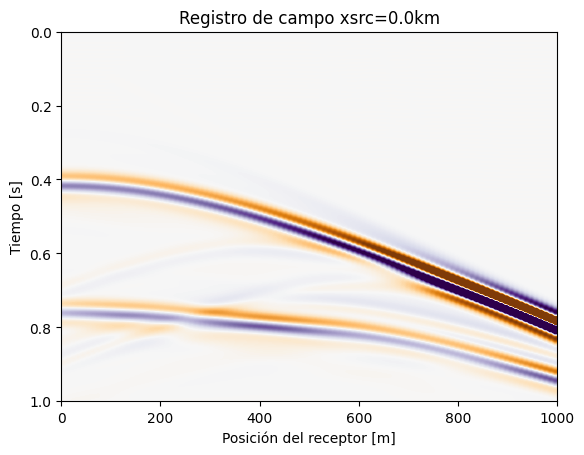

In [27]:
fig = figure() #dpi=300
imshow(dD.data[1], vmin=-1, vmax=1, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
xlabel("Posición del receptor [m]")
ylabel("Tiempo [s]")
title("Registro de campo xsrc=0.0km")
display(fig)

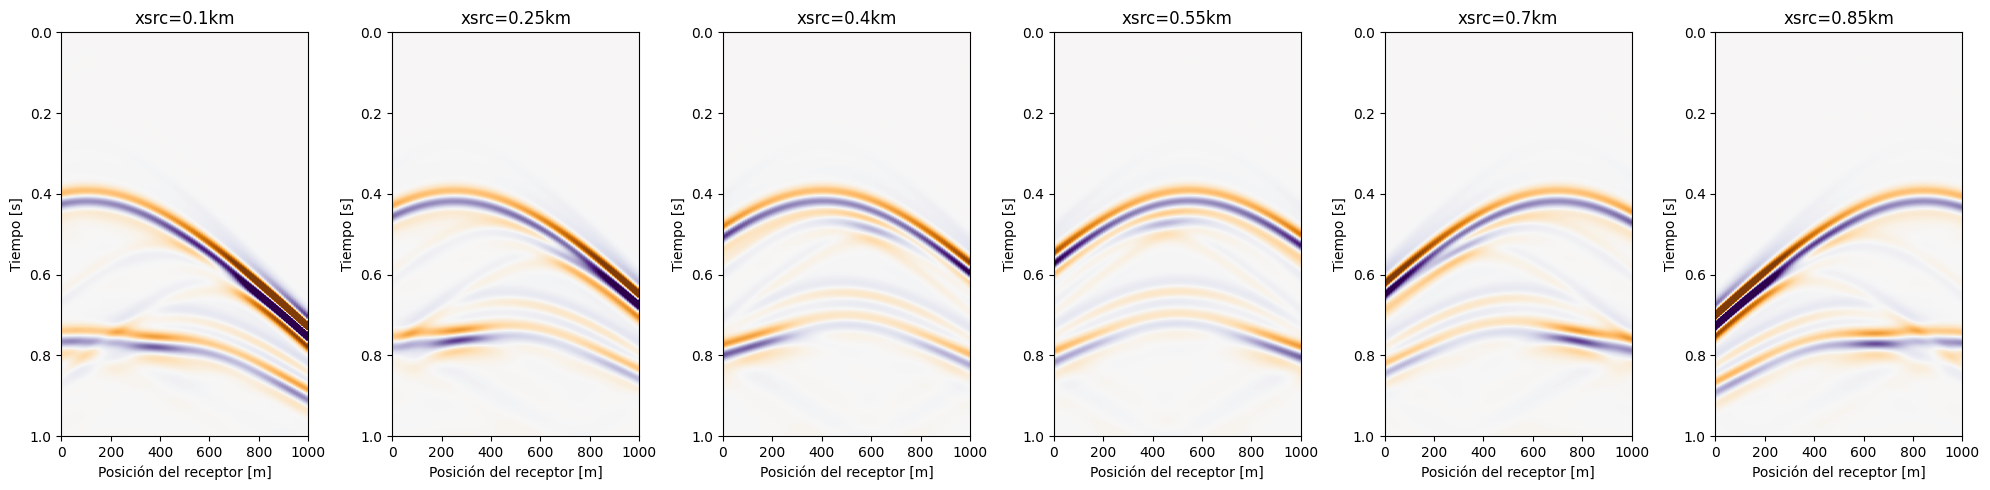

In [28]:
fig=figure(figsize=(20, 5)) #, dpi=300
for i=1:6
    subplot(1, 6, i)
    imshow(dD.data[3*i], vmin=-1, vmax=1, cmap="PuOr", extent=[xrec[1], xrec[end], timeD/1000, 0], aspect="auto")
    xlabel("Posición del receptor [m]")
    ylabel("Tiempo [s]")
    title("xsrc=$(round(1f-3xsrc[3*i][1]; digits = 2))km")
end

tight_layout()
display(fig)

### SEG-Y

In [29]:
block = judiVector_to_SeisBlock(d_obs, q)
segy_write("model_custom_high_f.segy", block)  # writes a SEG-Y file called new_file.segy

In [30]:
block = judiVector_to_SeisBlock(dD, q)
segy_write("model_custom_high_f_lin.segy", block)  # writes a SEG-Y file called new_file.segy